In [1]:

import numpy as np 
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage.transform import resize
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img
import pandas as pd
import random
from tqdm import tqdm
import glob
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras.layers import Layer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fonction qui parcour un directory et affiche des informations

In [3]:
def walk_through_dir(dir):
  for dirpath, filenames , dirnames in os.walk(dir):
    print('there are ',len(dirnames),' dir and ',len(filenames),' files in ',dirpath)

## Fonction qui récupère les images x_train et y_train et les reshape en (224 , 224 , 3) depuis le drive 

In [4]:
def x_data(): 

  path= 'drive/MyDrive/Code/for_sharing/all_segmented'
  folders=glob.glob(path+'/*')

  for f in folders[::]: 
    if f.endswith('.json'):
      folders.remove(f)

  train_path=[]
  test_path=[]

  for plante in folders: 

    for img in glob.glob(plante+'/img.png'):
  
      if img.rfind('test') != -1 :

        test_path.append(img)
      else :

        train_path.append(img)

  train_path.sort()
  test_path.sort()


  x_train= np.zeros((len(train_path),224,224,3) , dtype="float32")
  x_test= np.zeros((len(test_path),224,224,3) , dtype="float32")

  

  for i,path in enumerate(train_path):
    image = np.asarray(PIL.Image.open(path)) 
    image= cv2.resize(image, (224,224))
    #image= image/255
    x_train[i]=image


  
  for i,path in enumerate(test_path) : 
    image = np.asarray(PIL.Image.open(path)) 
    image= cv2.resize(image, (224,224))
    #image= image/255
    x_test[i]=image
    


  return x_train , x_test


## Fonction qui permet de rendre une image Y (segmentée) sous forme ONE HOT ENCODING avec le shape (224 , 224 , 3)

In [4]:
def one_hot(images):
  data=list()
  labels=[0,1,2]

  for i in images: 
    temp= np.asarray(PIL.Image.open(i))
    temp = cv2.resize(temp, (224,224))
    new_format= np.zeros(temp.shape+(3,))
    for l in labels :
      new_format[temp==l,l]=1
    data.append( new_format)

  return data

## Fonction qui permet de récupérer les images segmentées y_train du drive pour ensuite appeller la fonction ONE-HOT sur le resultat qui est retourné sous forme d'un array de taille : (nombre_image , 224 , 224 , 3) 

In [5]:
def Ytrain_data():


  path = 'drive/MyDrive/Code/for_sharing/train'

  folder = glob.glob(path+'/*')

  y_train_path=[]

  for path in folder:
    for image in glob.glob(path+'/*.png'):
      y_train_path.append(image)

  y_train_path.sort()

  return np.array(one_hot(y_train_path))
	

## Fonction qui récupère les Y_test ( même fonctionnement que Y_train)

In [6]:
def Ytest_data():


  path = 'drive/MyDrive/Code/for_sharing/test'

  folder = glob.glob(path+'/*')

  y_test_path=[]

  for path in folder:
    for image in glob.glob(path+'/*.png'):
      y_test_path.append(image)

  y_test_path.sort()

  return np.array(one_hot(y_test_path))

## Définition de deux classes MaxPoolingwithArgmax2D et MaxUnpooling2D qui héritent de la classer LAYER  de tensorflow.Keras 🇰

 • MaxPoolingwithArgmax2D : vu qu'il n'existe pas de layer MaxPool qui stocke les indices des poolings prédifini sur Keras , j'ai du créer une nouvelle classe Layer qui utilise la fonction du backend Keras suivante : **K.tf.nn.max_pool_with_argmax** qui retounre deux elements : l'output du pooling et les indices du pooling sur la feature map .



 • MaxUnpooling2D : classe qui a pour but de faire un upSampling sous forme de Unpooling en utilisant les indices génerés par le layer précèdent .


 Les fonctions call sont appellées quand une input est donnée à une classe Layer. 






In [5]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

## Définition du modele SEGNET comportant un encodeur avec la même architecture qu'un VGG16 (sauf la FC) et d'un décodeur utilisant des upsamplings en UNpooling avec les deux layers qu'on a définit juste avant pour la sauvegarde des indices du MaxPooling . 

 • L'input shape est (224,224,3) 
 • À la fin du décodeur , une softmax est appliquée sur chaques pixel des features maps 

In [6]:
from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers import Activation, Reshape
from keras.layers import BatchNormalization
from keras.models import Model



def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)
    

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Le Modele Encodeur est prêt..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0] , input_shape[1],n_labels),
        input_shape=(input_shape[0], input_shape[1],n_labels),
    )(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Le Modele Decodeur est prêt..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [ ]:
model = segnet((224, 224, 3), 3)
print(model.summary())

In [8]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train,y_train, validation_data=(x_test, y_test),batch_size=8,epochs=100)

Epoch 1/100
23/23 [==============================] - 12s 399ms/step - loss: 1.1336 - accuracy: 0.4841 - val_loss: 1.0837 - val_accuracy: 0.4337
Epoch 2/100
23/23 [==============================] - 9s 375ms/step - loss: 0.9534 - accuracy: 0.5911 - val_loss: 1.0189 - val_accuracy: 0.3780
Epoch 3/100
23/23 [==============================] - 9s 384ms/step - loss: 0.8970 - accuracy: 0.6194 - val_loss: 0.9837 - val_accuracy: 0.3880
Epoch 4/100
23/23 [==============================] - 9s 385ms/step - loss: 0.8760 - accuracy: 0.6132 - val_loss: 0.9873 - val_accuracy: 0.5048
Epoch 5/100
23/23 [==============================] - 9s 376ms/step - loss: 0.8367 - accuracy: 0.6279 - val_loss: 0.8622 - val_accuracy: 0.6405
Epoch 6/100
23/23 [==============================] - 8s 369ms/step - loss: 0.8325 - accuracy: 0.6334 - val_loss: 0.7833 - val_accuracy: 0.6806
Epoch 7/100
23/23 [==============================] - 8s 366ms/step - loss: 0.8292 - accuracy: 0.6342 - val_loss: 0.8119 - val_accuracy: 0.630

In [ ]:
""" 
Fonction qui permet de plot les courbes d'accuracy et de loss selon le train et le test """


def plot_loss_curves(history):

  loss= history.history['loss']
  accuracy= history.history['accuracy']

  val_loss=history.history['val_loss']
  val_accuracy=history.history['val_accuracy']

  epochs= range(len(history.history['loss']))

  plt.figure()
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.plot(epochs, accuracy ,label='training accuracy' )
  
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, val_loss, label='validation loss')
  plt.plot(epochs, loss ,label='training loss' )
  
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()






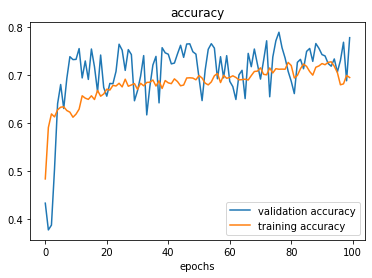

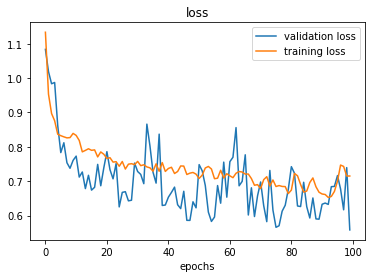

In [ ]:
plot_loss_curves(hist)

In [ ]:
preds= SEGNET.predict(x_test)

In [ ]:
loss, accuracy= SEGNET.evaluate(x_test, y_test)

1/1 [==============================] - 0s 230ms/step - loss: 0.5582 - accuracy: 0.7780
